<a href="https://colab.research.google.com/github/suminkim1021/wiset/blob/main/GradCam_sumin_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,models,transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.optim import lr_scheduler
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [ ]:
import random
random.seed(777)

In [ ]:
#image_dataset을 imageFolder를 사용하여 저장
image_dataset =datasets.ImageFolder(root='/content/drive/MyDrive/CTData',transform=transforms.ToTensor())

In [ ]:
meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in image_dataset]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in image_dataset]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.5956638 0.5952743 0.5951023
0.29826552 0.29836467 0.29833674


In [ ]:
# 구한 mean,std 값으로 normalization하기 
data_transform=transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.Normalize([meanR, meanG, meanB],[stdR, stdG, stdB])])

In [ ]:
image_dataset.transform=data_transform
print(image_dataset)

Dataset ImageFolder
    Number of datapoints: 746
    Root location: /content/drive/MyDrive/CTData
    StandardTransform
Transform: ToTensor()


In [ ]:
class_names=image_dataset.classes #클래스 출력
print(class_names)

['CT_COVID', 'CT_NonCOVID']


In [ ]:
#torch.utils.data.random_split() 방법을 이용하여 분할

train_size=int(0.8*len(image_dataset))
test_size=len(image_dataset)-train_size

train_dataset,test_dataset=torch.utils.data.random_split(image_dataset,[train_size,test_size])

In [ ]:
#train,test로 분할된 것 확인
numTrain=len(train_dataset)
print('train data 수: ' ,numTrain)
numTest=len(test_dataset)
print('test data 수: ' ,numTest)

train data 수:  596
test data 수:  150


In [ ]:
train_loader=DataLoader(train_dataset,batch_size=20,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=10,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


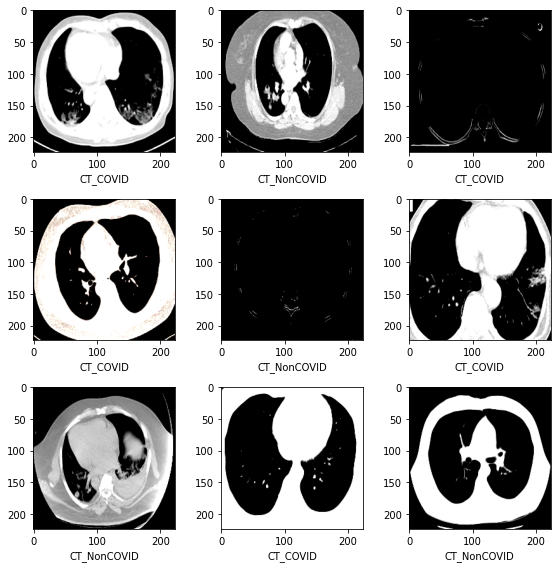

In [ ]:
# 전체 train 이미지 중 9개를 랜덤으로 골라 3x3으로 레이블과 함께 그리기

plt.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTrain, size=9)): 
    img,label=train_dataset[k] 
    arr=np.transpose(img,(1,2,0))                     
    plt.subplot(3,3,i+1)
    plt.xlabel(class_names[label])
    plt.imshow(arr)
plt.tight_layout()
plt.show()

In [ ]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(train_dataset,
                                batch_size=30,
                                shuffle=True,
                                num_workers=0),  
    'test':
    torch.utils.data.DataLoader(test_dataset,
                                batch_size=20,
                                shuffle=True,
                                num_workers=0)  
}

In [ ]:
# model
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# ResNet50 model

model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True  
    

In [ ]:
#loss, optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
 
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'test': len(dataloders['test'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                test_epoch_loss = running_loss / dataset_sizes[phase]
                test_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'test' and test_epoch_acc > best_acc:
                best_acc = test_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'test loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                test_epoch_loss, test_epoch_acc))
            


    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model= train_model(dataloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0/9] train loss: 0.0214 acc: 0.6124 test loss: 0.0291 acc: 0.7667


KeyboardInterrupt: ignored

# 태희언니 코드로 하는 GRAD CAM

In [ ]:
!pwd

/content


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
import pytorch_grad_cam

In [ ]:
test_loader=DataLoader(test_dataset,batch_size=2,shuffle=False)

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = resnet50(pretrained=True)
target_layer = model.layer4[-1]
input_tensor = test_loader
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layer=target_layer, use_cuda= 'cuda')

# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = 281

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam)